In [5]:
import torch
import numpy as np
from pathlib import Path
import itertools

from unet_film2 import UNet
from inference import InferenceLoop
import data_loader as dl

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

In [6]:

CHECKPOINT_PATH = "/hs/babbage/data/group-brueggen/David/diff.clean_save/unet_reconstruction_new_combined_loss/unet_final_cycle_5.pt" #unet_reconstruction_LogHuber_Sky_image_is_loss_two_opt_loss_with_masking_res_no_abs/unet_final_cycle_5.pt"#"/hs/babbage/data/group-brueggen/David/diff.clean_save/unet_final_cycle_5.pt"

PIX_SIZE = 512
FOV_ARCSEC = 6000
EPS = 1e-6

NUM_MAJOR_CYCLES = 5   # Anzahl der Zyklen für inference
BATCH_SIZE = 1         # Für inference meist 1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

Device: cuda


In [7]:
unet = UNet(
    num_conditions=NUM_MAJOR_CYCLES + 1,
    in_channels=2,
    out_channels=1,
    base_c=32,
)


infer = InferenceLoop(
    unet=unet,
    pix_size=PIX_SIZE,
    fov_arcsec=FOV_ARCSEC,
    device=DEVICE,
    use_wandb=False
)

infer.load_checkpoint(CHECKPOINT_PATH)

[Inference] Loaded checkpoint: /hs/babbage/data/group-brueggen/David/diff.clean_save/unet_reconstruction_new_combined_loss/unet_final_cycle_5.pt


/hshome/bav1814/Desktop/diff.clean/inference.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt_path, map_location=map_location)


In [8]:
data_path = Path("/hs/babbage/data/group-brueggen/David/Kevin_webdataset_all")
shards = sorted(data_path.glob("train-*.tar"))  # oder "test-"
shards = [str(f) for f in shards]

dataloader = dl.make_webdataset_dataloader(
    shards,
    batch_size=BATCH_SIZE,
    shuffle=0,
    num_workers=4,
)

# Nimm einen Batch
#batch = next(iter(dataloader))
n = 90
batch = next(itertools.islice(dataloader, n, None))

vis = batch[0][0].cfloat()     # (B,Nvis)
uvw = batch[0][1].float()
lmn = batch[0][2].float()
sky_true = batch[1].sum(dim=1).float()   # (B, H, W)

print("vis:", vis.shape)
print("uvw:", uvw.shape)
print("lmn:", lmn.shape)
print("sky:", sky_true.shape)

vis: torch.Size([1, 9831992])
uvw: torch.Size([1, 3, 9831992])
lmn: torch.Size([1, 3, 262144])
sky: torch.Size([1, 512, 512])


In [9]:
result = infer.run_major_minor(
    vis=vis,
    uvw=uvw,
    lmn=lmn,
    num_major_cycles=NUM_MAJOR_CYCLES,
)

model_image = result["model_image"][0,0].detach().cpu()
residual_image = result["res_image"]
resmean = result["resmean"].detach().cpu()

/hshome/bav1814/Desktop/diff.clean/finufft_dlpack.py:18: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return cp.fromDlpack(torch.utils.dlpack.to_dlpack(x_torch))
/hshome/bav1814/Desktop/diff.clean/finufft_dlpack.py:13: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return torch.utils.dlpack.from_dlpack(x_cp.toDlpack())
/hshome/bav1814/Desktop/diff.clean/inference.py:105: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:305.)
  residual_image = residual_image.reshape(batchsize, self.pix_size, self.pix_size).float()


[Inference] Major 0/5 — resmean 0.941425
[Inference] Major 1/5 — resmean 0.614516
[Inference] Major 2/5 — resmean 0.406281
[Inference] Major 3/5 — resmean 0.328663
[Inference] Major 4/5 — resmean 0.320566


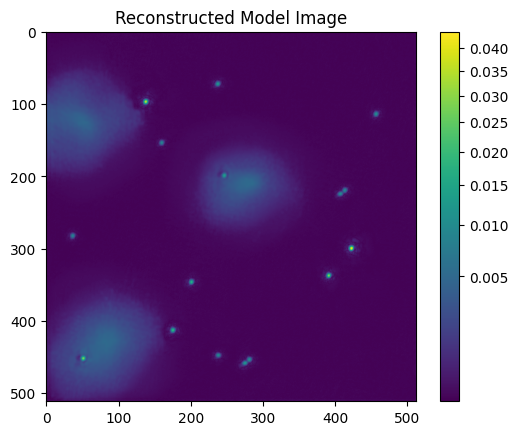

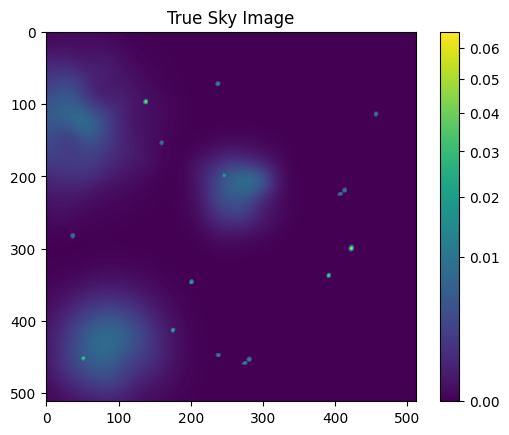

In [10]:
plt.imshow(model_image, norm=PowerNorm(0.5))
plt.colorbar()
plt.title("Reconstructed Model Image")
plt.show()
plt.imshow(sky_true[0,...].cpu(),norm=PowerNorm(0.5))
plt.colorbar()
plt.title("True Sky Image")
plt.show()



In [11]:
from pytorch_msssim import ssim
ssim_index = ssim(model_image.unsqueeze(0).unsqueeze(0), sky_true[0,...].unsqueeze(0).unsqueeze(0), data_range=sky_true.max().item(), size_average=True)
print("SSIM Index:", ssim_index.item())

SSIM Index: 0.961875319480896


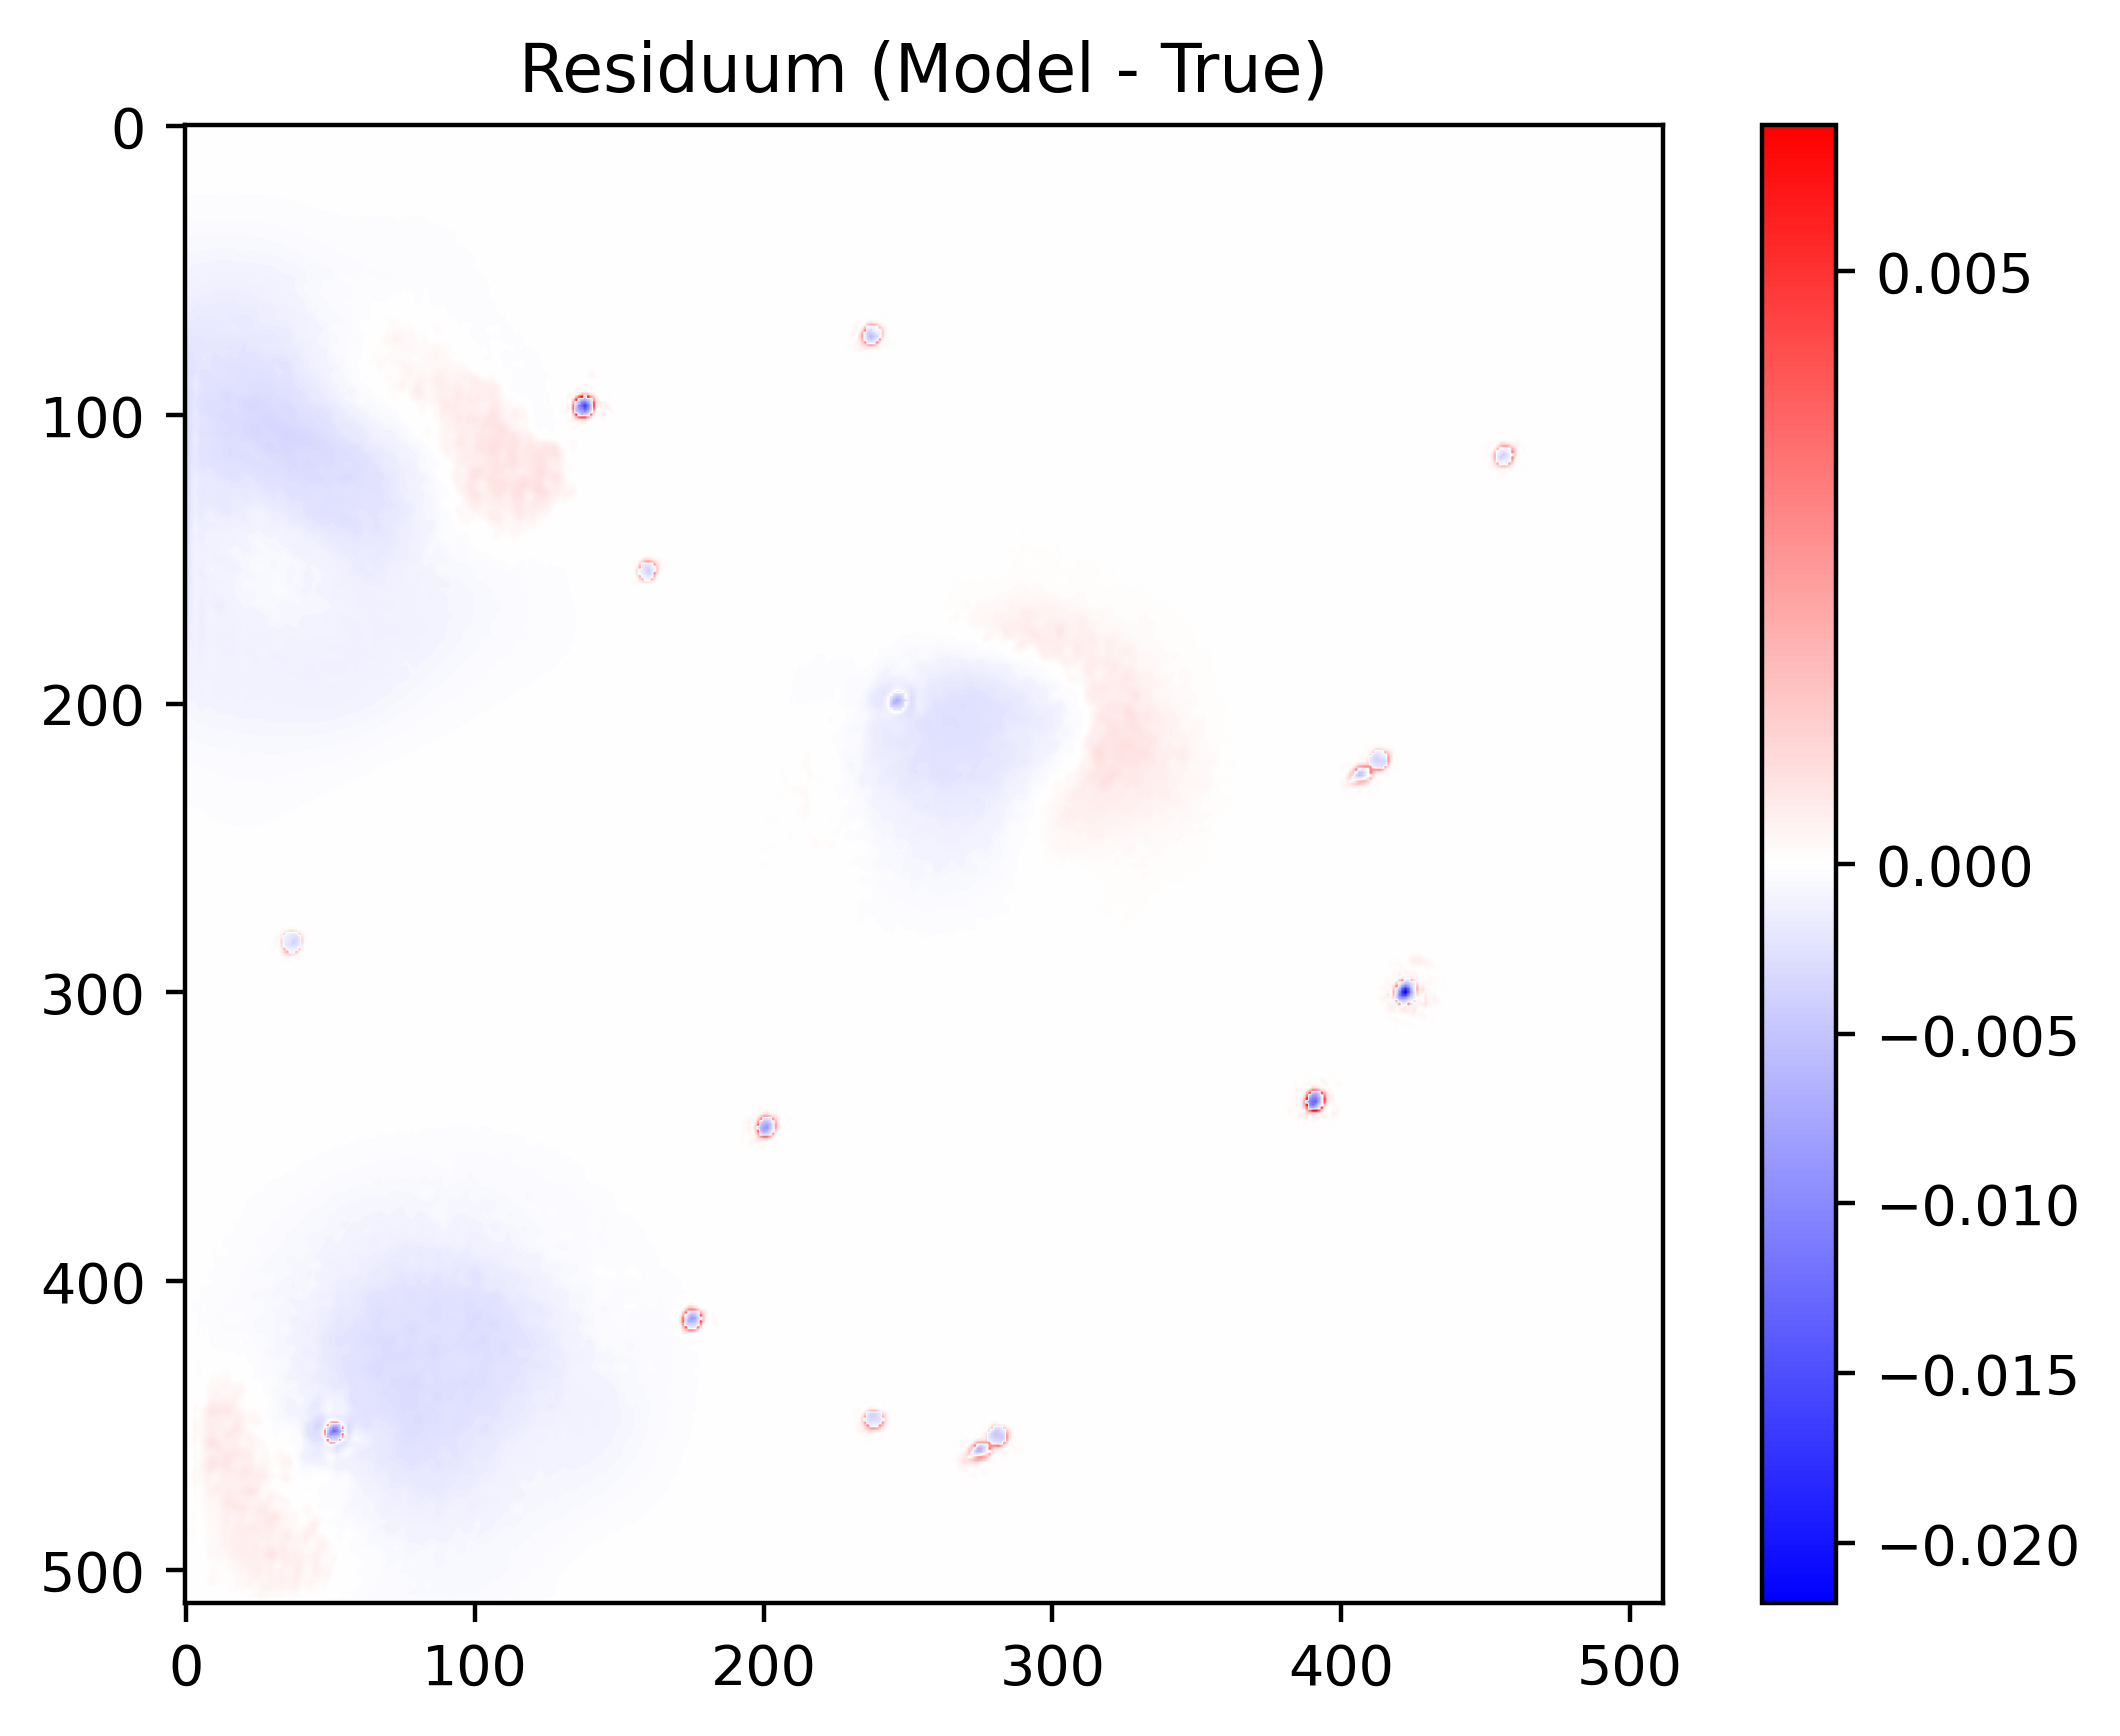

In [12]:
### Residuum
from matplotlib.colors import TwoSlopeNorm
res = model_image - sky_true[0,...].cpu()
plt.figure(dpi=400)
plt.imshow(res, norm=TwoSlopeNorm(vmin=res.min(), vcenter=0, vmax=res.max()),cmap='bwr')
plt.colorbar()
plt.title("Residuum (Model - True)")
plt.show()




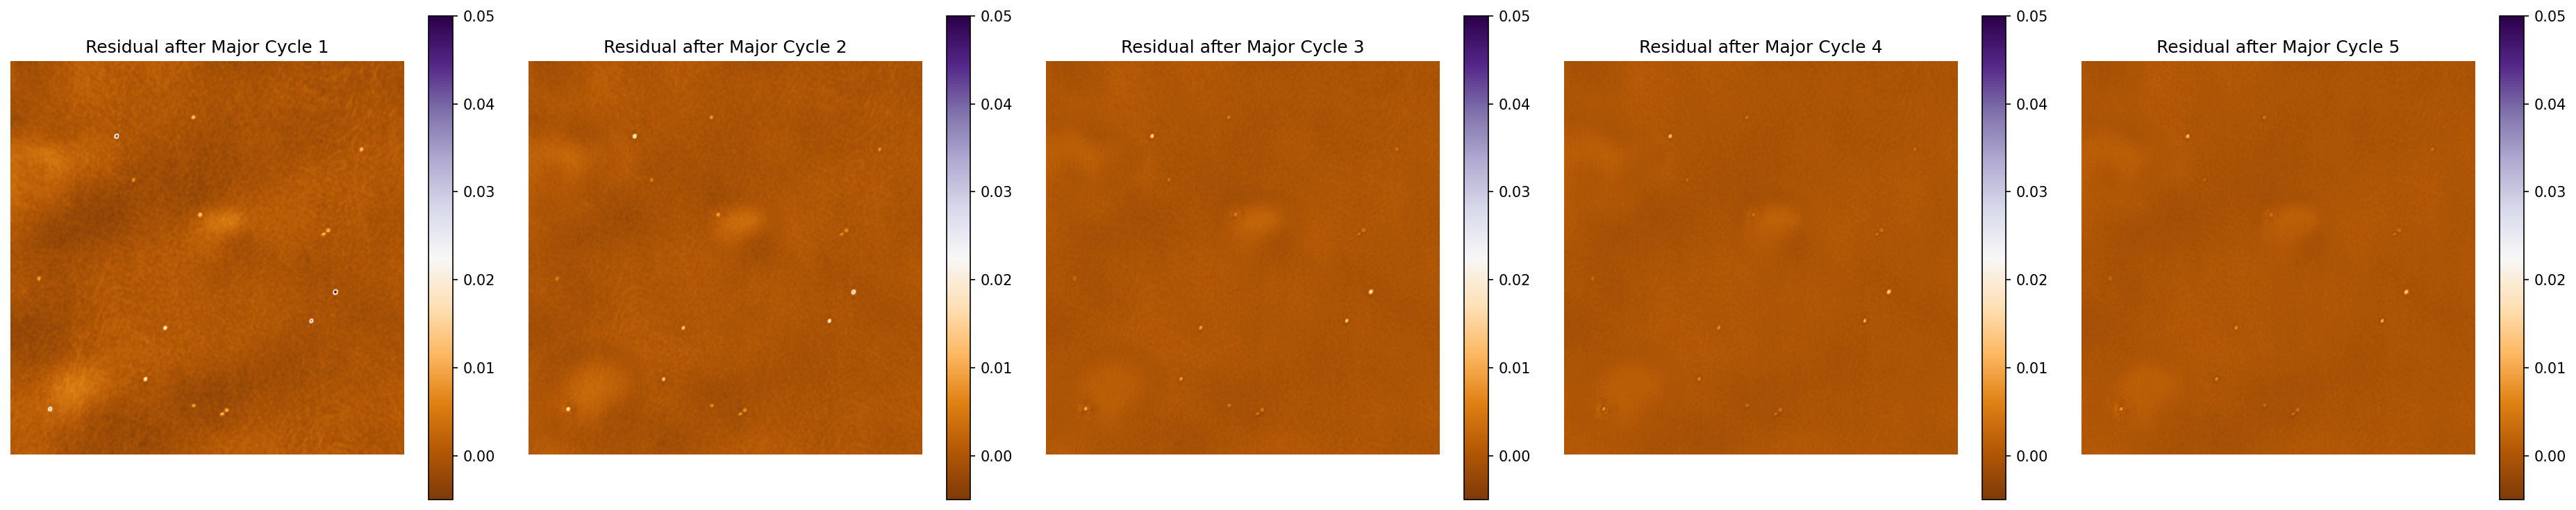

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

num_cycles = len(residual_image)

# Figure erstellen: alle Plots nebeneinander
fig, axes = plt.subplots(1, num_cycles, figsize=(5*num_cycles, 5), dpi=150)

# Falls num_cycles == 1 → axes ist kein Array, daher fixen:
if num_cycles == 1:
    axes = [axes]

# Alle Residual-Bilder plotten
for i, ax in enumerate(axes):
    im = ax.imshow(
        residual_image[i][0,...],  # (H,W)
        #norm=PowerNorm(0.5),
        cmap="PuOr",
        vmax=0.05,
        vmin=-0.005
    )
    ax.set_title(f"Residual after Major Cycle {i+1}")
    ax.axis('off')  # Achsen optional ausblenden

    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

# Vorbereitung für inspect recos

In [11]:
from torch.utils.data import DataLoader
import os
import h5py

RUN_NAME = "twoopt_unbinned_new_loss"
data_path = Path("/hs/babbage/data/shared/eval_data/h5")
save_path = Path(f"/hs/babbage/data/group-brueggen/David/diff.clean_rekonstruktion/{RUN_NAME}")
os.makedirs(save_path, exist_ok=True)

data=dl.get_paths(data_path, "valid")
print("Data path:", data)
shards = sorted(data_path.glob("train-*.tar"))  # oder "test-"
shards = [str(f) for f in shards]


dataset = dl.BufferedVisDataSet(data, preload_size=len(data))
print(dataset)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=20)

# Nimm einen Batch
#batch = next(iter(dataloader))
for i, j in enumerate(data_loader):
    vis=j[0][0].cfloat()
    uvw=j[0][1].float()
    lmn=j[0][2].float()
    sky_true=j[1].sum(dim=1).float()
    result = infer.run_major_minor(
        vis=vis,
        uvw=uvw,
        lmn=lmn,
        num_major_cycles=NUM_MAJOR_CYCLES)
    with h5py.File(save_path/f"eval_{i}.h5", "w") as f:
        f.create_dataset("reco", data=result["model_image"].cpu().numpy())
        f.create_dataset("sky_true", data=sky_true.cpu().numpy())
        f.attrs.update({
            "num_major_cycles": NUM_MAJOR_CYCLES,
        })
    

Data path: [PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid0.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid1.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid2.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid3.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid4.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid5.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid6.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid7.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid8.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid9.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid10.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid11.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid12.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid13.h5'), PosixPath('/hs/babbage/data/shared/eval_data/h5/samp_valid14

In [14]:
import h5py 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from astropy.io import fits
from natsort import natsorted
RUN_NAME = "twoopt_unbinned_new_loss"
save_path = Path(f"/hs/babbage/data/group-brueggen/David/diff.clean_rekonstruktion/{RUN_NAME}")



[PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_0-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_1-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_2-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_3-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_4-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_5-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_6-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_7-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_8-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_9-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_10-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_11-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_12-image.fits'), PosixPath('/hs/babbage/data/shared/eval_data/wsclean/ms_13-i

/tmp/ipykernel_3400002/1487213180.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  reco = np.array(f_reco["reco"])
/tmp/ipykernel_3400002/1487213180.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  sky_true = np.array(f_reco["sky_true"])


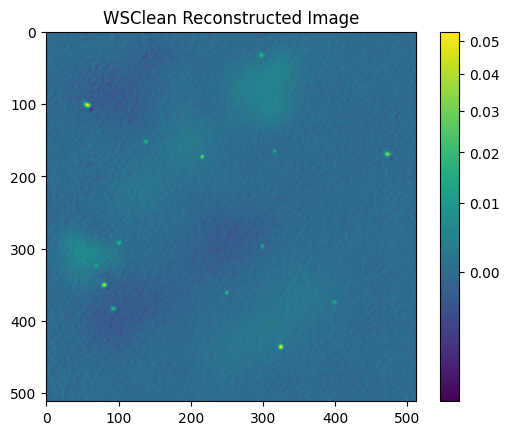

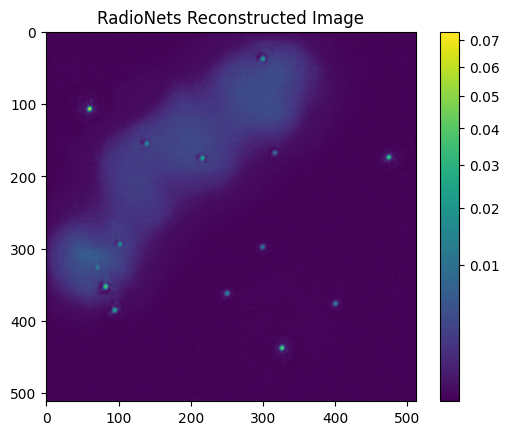

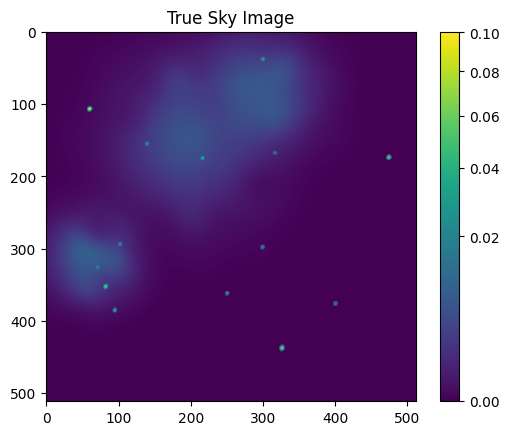

In [15]:
n=5
def find_files(directory, phrase):
    directory = Path(directory)
    return natsorted([file for file in directory.glob('*') if phrase in file.name])
files_wsclean = find_files("/hs/babbage/data/shared/eval_data/wsclean/", "image")
print(files_wsclean)

def open_wsclean(path):
    f_wsclean = fits.open(path)
    reco_ws = f_wsclean[0].data[0, 0][::-1]
    return reco_ws

def open_radionets(path):
    f_reco = h5py.File(path)
    reco = np.array(f_reco["reco"])
    sky_true = np.array(f_reco["sky_true"])
    return reco, sky_true

ws_clean_images = open_wsclean(files_wsclean[n])
radionets_images, sky_true_images = open_radionets(save_path/f"eval_{n}.h5")
plt.imshow(ws_clean_images, norm=PowerNorm(0.5))
plt.colorbar()
plt.title("WSClean Reconstructed Image")
plt.show()
plt.imshow(radionets_images[0,0], norm=PowerNorm(0.5))
plt.colorbar()
plt.title("RadioNets Reconstructed Image")
plt.show()
plt.imshow(sky_true_images[0,...], norm=PowerNorm(0.5))
plt.colorbar()
plt.title("True Sky Image")
plt.show()
